# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, Rule, ProfilerRule, rule_configs, TensorBoardOutputConfig
from sagemaker.pytorch import PyTorch
from sagemaker.predictor import Predictor
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.debugger import CollectionConfig
from sagemaker.pytorch import PyTorchModel
import os
import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()                                ## TODO: fill in
print("Default Bucket: {}".format(bucket))

my_session = boto3.session.Session()
region = my_session.region_name## TODO: fill in
print("AWS Region: {}".format(region))


role = get_execution_role()## TODO: fill in
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-697405440952
AWS Region: us-east-1
RoleArn: arn:aws:iam::697405440952:role/service-role/AmazonSageMaker-ExecutionRole-20211126T034962


In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
   
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.

from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="dog_image_classification_resnet18",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.4.0",
    py_version="py3"
)# TODO: Your estimator here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)
# TODO: Your HP tuner here

In [7]:
# TODO: Fit your HP Tuner

s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")


os.environ['SM_CHANNEL_TRAIN']=s3_data
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir


tuner.fit({'train' : s3_data},wait=True) 

#tuner.fit() # TODO: Remember to include your data channels


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-22 10:46:27 Starting - Preparing the instances for training
2022-01-22 10:46:27 Downloading - Downloading input data
2022-01-22 10:46:27 Training - Training image download completed. Training in progress.
2022-01-22 10:46:27 Uploading - Uploading generated training model
2022-01-22 10:46:27 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'lr': '0.0026000751895274388',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog_image_classification_resnet18-2022-01-22-10-08-07-233"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-697405440952/dog_image_classification_resnet18-2022-01-22-10-08-07-233/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import CollectionConfig
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
#how to set up debbugging, collectionconfigs
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]
debugger_config=DebuggerHookConfig(collection_configs=collection_configs)


In [10]:
# TODO: Create and fit an estimator
#import os
hyperparameters = {"batch_size": "64", "lr": "0.0026000751895274388"} 
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

#estimator = estimator.fit(wait=True)# TODO: Your estimator here
#in your notebook, you should specify the location of your training data:(this is from knowledge)
estimator.fit({'train':s3_data}, wait=True)

2022-01-22 10:50:47 Starting - Starting the training job...
2022-01-22 10:51:11 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-22 10:52:16 Starting - Preparing the instances for training......
2022-01-22 10:53:17 Downloading - Downloading input data.........
2022-01-22 10:54:37 Training - Downloading the training image...
2022-01-22 10:55:18 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-22 10:55:12,862 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-22 10:55:12,883 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-22 10:55:15,897 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022

In [11]:
# TODO: Plot a debugging output.
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-01-22-10-50-46-957
Region: us-east-1
[2022-01-22 10:58:41.170 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:460 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-22 10:58:41.196 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:460 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/debug-output
[2022-01-22 10:58:42.719 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:460 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-22 10:58:43.744 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:460 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 

In [12]:
tensor_name = "CrossEntropyLoss_output_0"

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [14]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 [array(4.9037213, dtype=float32),
  array(4.815762, dtype=float32),
  array(4.349121, dtype=float32),
  array(3.650629, dtype=float32),
  array(2.995731, dtype=float32),
  array(2.5247085, dtype=float32),
  array(2.4289143, dtype=float32),
  array(2.0851223, dtype=float32),
  array(2.5084088, dtype=float32),
  array(1.9760199, dtype=float32),
  array(2.073456, dtype=float32)])

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


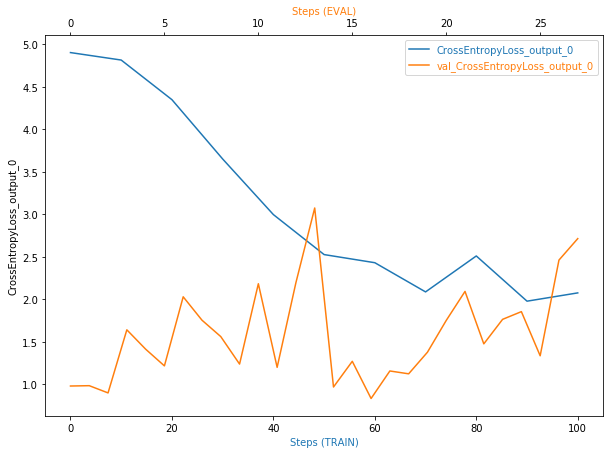

In [17]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [18]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/rule-output


In [19]:
! aws s3 ls {rule_output_path} --recursive

2022-01-22 10:57:40     335924 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-22 10:57:39     178317 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-22 10:57:35        191 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-22 10:57:35       8358 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-22 10:57:35        126 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-22 10:57:35        129 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-22 10:57:35       3654 pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-re

In [20]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-training-2022-01-22-10-50-46-957/r

In [21]:
#import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

## Model Deploying

In [22]:
model_location=estimator.model_data

In [24]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [40]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='reference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [41]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

--------!

In [42]:
with open("./Bernese_mountain_dog_01638.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

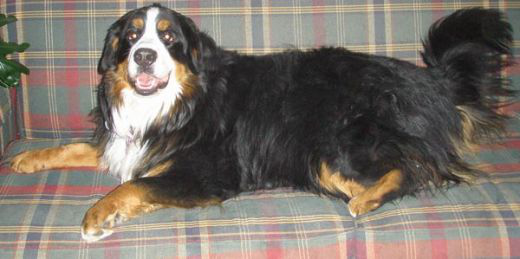

In [43]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [44]:
# TODO: Run an prediction on the endpoint
result=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

In [45]:
import numpy as np
np.argmax(result, 1)

array([22])